## Assignment: Image recognition
- Alumno 1:
- Alumno 2:
- Alumno 3:

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/4oNHlRFEd71HXp4](https://drive.upm.es/s/4oNHlRFEd71HXp4)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp "/content/gdrive/MyDrive/xview_recognition.zip" "/content/"

In [ ]:
!unzip "/content/xview_recognition.zip"

Output streaming troncato alle ultime 5000 righe.
  inflating: xview_train/Shipping container/778dd2fe-ad63-4889-9380-8a7acba75977.tif  
  inflating: xview_train/Shipping container/7535dd1d-92f1-4007-8264-a6750c99a899.tif  
  inflating: xview_train/Shipping container/199e85aa-99c7-470b-9066-073634f2e02c.tif  
  inflating: xview_train/Shipping container/a4d2949f-f9f3-4fd3-ace0-4af8400bfd4a.tif  
  inflating: xview_train/Shipping container/44430654-4ec0-4f66-b6fa-86448807b011.tif  
  inflating: xview_train/Shipping container/ce8e443f-b915-486e-af5c-13e5f2ebb9f1.tif  
  inflating: xview_train/Shipping container/1ae7c2a0-63ee-46d4-acaa-b86d3af581b8.tif  
  inflating: xview_train/Shipping container/6efd49ec-7789-483c-93d5-90fe2d5098b0.tif  
  inflating: xview_train/Shipping container/cf285f00-3242-4259-895b-2da7282c0aaa.tif  
  inflating: xview_train/Shipping container/6d96f2ec-ed73-4639-abe7-53485b52db05.tif  
  inflating: xview_train/Shipping container/c7fc8511-d3a7-4ae9-bc6d-4d5ce506cb9c

In [ ]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [ ]:
categories = {0: 'Cargo plane', 1: 'Helicopter', 2: 'Small car', 3: 'Bus', 4: 'Truck', 5: 'Motorboat', 6: 'Fishing vessel', 7: 'Dump truck', 8: 'Excavator', 9: 'Building', 10: 'Storage tank', 11: 'Shipping container'}

In [ ]:
pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 36.4 MB/s eta 0:00:00


In [ ]:
import warnings
import rasterio
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open(filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

def generator_images(objs, batch_size, data_augmentation=False, do_shuffle=False):
    if data_augmentation:
        # Define data augmentation parameters
        data_gen = ImageDataGenerator(
             rotation_range=20,
             width_shift_range=0.2,
             height_shift_range=0.2,
             shear_range=0.2,
             zoom_range=0.2,
             horizontal_flip=True,
             fill_mode='nearest'
        )

    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i + batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                img = load_geoimage(filename)
                # Apply data augmentation if enabled
                if data_augmentation:
                    img = data_gen.random_transform(img)
                images.append(img)
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            if images:
                images = np.array(images).astype(np.float32)
                labels = np.array(labels).astype(np.float32)
                yield images, labels
            else:
                # Handle case where there are no more images
                break



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)

#### Training
Design and train a ffNN to deal with the “xview_recognition” classification task.

In [ ]:
import json

# Load database
json_file = 'xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [ ]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'Cargo plane': 635, 'Helicopter': 70, 'Small car': 4290, 'Bus': 2155, 'Truck': 2746, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 4689, 'Storage tank': 1469, 'Shipping container': 1523}


In [ ]:
from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TerminateOnNaN


# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model except the last few
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Create a new model on top of the pre-trained model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))  # Add L2 regularization
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))  # Add L2 regularization
model.add(Dropout(0.5))
model.add(Dense(len(categories), activation='softmax'))

model.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                         

In [ ]:
# Compile the model with a lower learning rate
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Callbacks
model_checkpoint = ModelCheckpoint('model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=40, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [ ]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
batch_size = 32
train_generator = generator_images(objs_train, batch_size, do_shuffle=True)
valid_generator = generator_images(objs_valid, batch_size, do_shuffle=False)

In [ ]:
import math
import numpy as np
print('Training model')
epochs = 30
train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)
h = model.fit(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=1)
# Best validation model
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Training model
Epoch 1/30
602/602 [==============================] - ETA: 0s - loss: 3.4051 - accuracy: 0.5039
Epoch 1: val_accuracy improved from -inf to 0.67212, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 145s 218ms/step - loss: 3.4051 - accuracy: 0.5039 - val_loss: 2.6228 - val_accuracy: 0.6721 - lr: 1.0000e-04
Epoch 2/30
602/602 [==============================] - ETA: 0s - loss: 2.4895 - accuracy: 0.6579
Epoch 2: val_accuracy improved from 0.67212 to 0.69738, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 112s 185ms/step - loss: 2.4895 - accuracy: 0.6579 - val_loss: 2.2382 - val_accuracy: 0.6974 - lr: 1.0000e-04
Epoch 3/30
602/602 [==============================] - ETA: 0s - loss: 2.0540 - accuracy: 0.7189
Epoch 3: val_accuracy improved from 0.69738 to 0.72825, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 111s 184ms/step - loss: 2.0540 - accuracy: 0.7189 - val_loss: 1.9386 - val_accuracy: 0.7283 - lr: 1.0000e-04
Epoch 4/30
602/602 [==============================] - ETA: 0s - loss: 1.7469 - accuracy: 0.7599
Epoch 4: val_accuracy improved from 0.72825 to 0.72965, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 111s 185ms/step - loss: 1.7469 - accuracy: 0.7599 - val_loss: 1.8532 - val_accuracy: 0.7297 - lr: 1.0000e-04
Epoch 5/30
602/602 [==============================] - ETA: 0s - loss: 1.4938 - accuracy: 0.7968
Epoch 5: val_accuracy improved from 0.72965 to 0.74696, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 114s 190ms/step - loss: 1.4938 - accuracy: 0.7968 - val_loss: 1.6535 - val_accuracy: 0.7470 - lr: 1.0000e-04
Epoch 6/30
602/602 [==============================] - ETA: 0s - loss: 1.2812 - accuracy: 0.8308
Epoch 6: val_accuracy improved from 0.74696 to 0.75912, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 114s 190ms/step - loss: 1.2812 - accuracy: 0.8308 - val_loss: 1.5067 - val_accuracy: 0.7591 - lr: 1.0000e-04
Epoch 7/30
602/602 [==============================] - ETA: 0s - loss: 1.1196 - accuracy: 0.8604
Epoch 7: val_accuracy did not improve from 0.75912
602/602 [==============================] - 120s 199ms/step - loss: 1.1196 - accuracy: 0.8604 - val_loss: 1.5047 - val_accuracy: 0.7484 - lr: 1.0000e-04
Epoch 8/30
602/602 [==============================] - ETA: 0s - loss: 0.9761 - accuracy: 0.8852
Epoch 8: val_accuracy did not improve from 0.75912
602/602 [==============================] - 110s 182ms/step - loss: 0.9761 - accuracy: 0.8852 - val_loss: 1.5852 - val_accuracy: 0.7535 - lr: 1.0000e-04
Epoch 9/30
602/602 [==============================] - ETA: 0s - loss: 0.8613 - accuracy: 0.9108
Epoch 9: val_accuracy did not improve from 0.75912
602/602 [==============================] - 109s 181ms/step - loss: 0.8613 - accuracy: 0.9108 - val_loss

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 114s 190ms/step - loss: 0.6965 - accuracy: 0.9434 - val_loss: 1.5334 - val_accuracy: 0.7703 - lr: 1.0000e-04
Epoch 12/30
602/602 [==============================] - ETA: 0s - loss: 0.6124 - accuracy: 0.9573
Epoch 12: val_accuracy did not improve from 0.77035
602/602 [==============================] - 109s 180ms/step - loss: 0.6124 - accuracy: 0.9573 - val_loss: 1.7499 - val_accuracy: 0.7474 - lr: 1.0000e-04
Epoch 13/30
602/602 [==============================] - ETA: 0s - loss: 0.5761 - accuracy: 0.9609
Epoch 13: val_accuracy did not improve from 0.77035
602/602 [==============================] - 110s 182ms/step - loss: 0.5761 - accuracy: 0.9609 - val_loss: 1.7152 - val_accuracy: 0.7535 - lr: 1.0000e-04
Epoch 14/30
602/602 [==============================] - ETA: 0s - loss: 0.5555 - accuracy: 0.9588
Epoch 14: val_accuracy did not improve from 0.77035
602/602 [==============================] - 109s 182ms/step - loss: 0.5555 - accuracy: 0.9588 - va

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 112s 187ms/step - loss: 0.2403 - accuracy: 0.9998 - val_loss: 1.9502 - val_accuracy: 0.7717 - lr: 1.0000e-05
Epoch 27/30
602/602 [==============================] - ETA: 0s - loss: 0.2281 - accuracy: 0.9995
Epoch 27: val_accuracy improved from 0.77175 to 0.77268, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 111s 184ms/step - loss: 0.2281 - accuracy: 0.9995 - val_loss: 1.9985 - val_accuracy: 0.7727 - lr: 1.0000e-05
Epoch 28/30
602/602 [==============================] - ETA: 0s - loss: 0.2138 - accuracy: 0.9998
Epoch 28: val_accuracy did not improve from 0.77268
602/602 [==============================] - 120s 199ms/step - loss: 0.2138 - accuracy: 0.9998 - val_loss: 1.9571 - val_accuracy: 0.7703 - lr: 1.0000e-05
Epoch 29/30
602/602 [==============================] - ETA: 0s - loss: 0.1992 - accuracy: 0.9995
Epoch 29: val_accuracy improved from 0.77268 to 0.77456, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 112s 185ms/step - loss: 0.1992 - accuracy: 0.9995 - val_loss: 1.9955 - val_accuracy: 0.7746 - lr: 1.0000e-05
Epoch 30/30
602/602 [==============================] - ETA: 0s - loss: 0.1829 - accuracy: 0.9999
Epoch 30: val_accuracy did not improve from 0.77456
602/602 [==============================] - 110s 182ms/step - loss: 0.1829 - accuracy: 0.9999 - val_loss: 1.9597 - val_accuracy: 0.7722 - lr: 1.0000e-05
Best validation model: epoch 29  - val_accuracy 0.7745556831359863


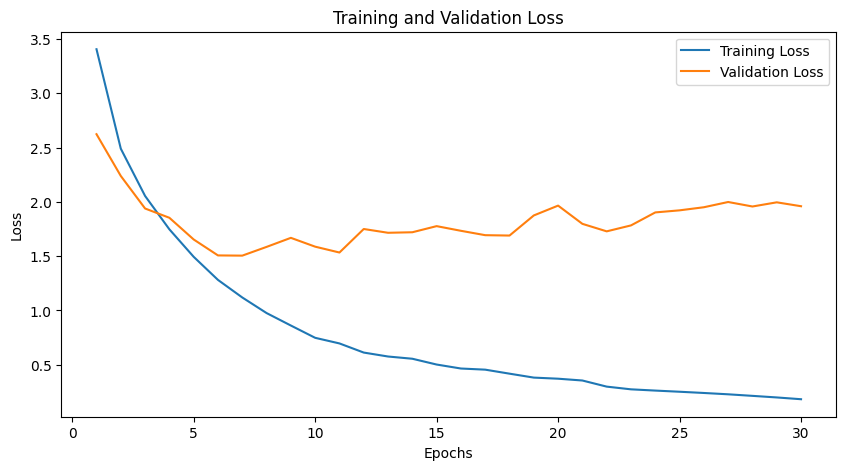

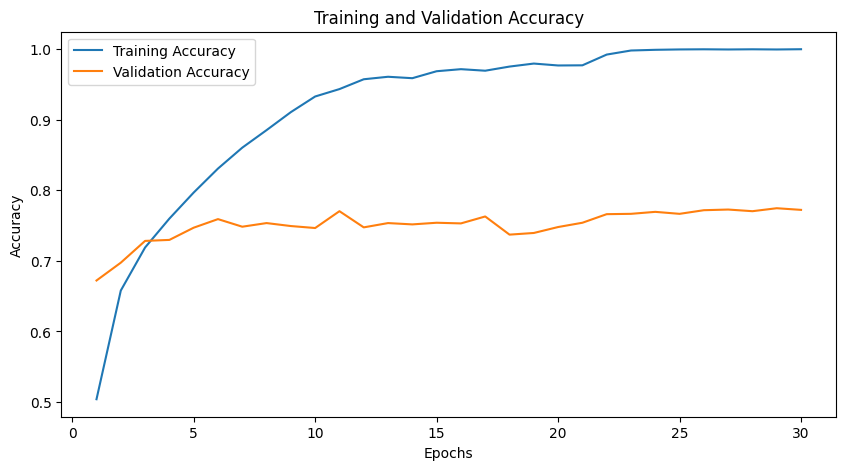

In [ ]:
# Plotting
epochs_range = range(1, epochs + 1)

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, h.history['loss'], label='Training Loss')
plt.plot(epochs_range, h.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, h.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, h.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

#### Testing
Try to improve the results provided in the Moodle competition wiki.

In [ ]:


import json

# Load database
json_file = 'xview_ann_test.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [ ]:
import numpy as np

anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    image.add_object(obj)
    anns.append(image)

In [ ]:
import numpy as np

# model.load_weights('model.hdf5', by_name=True)
y_true, y_pred = [], []
for ann in anns:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

1/1 [==============================] - 0s 39ms/step


<ipython-input-8-39df9ea0fe34>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))


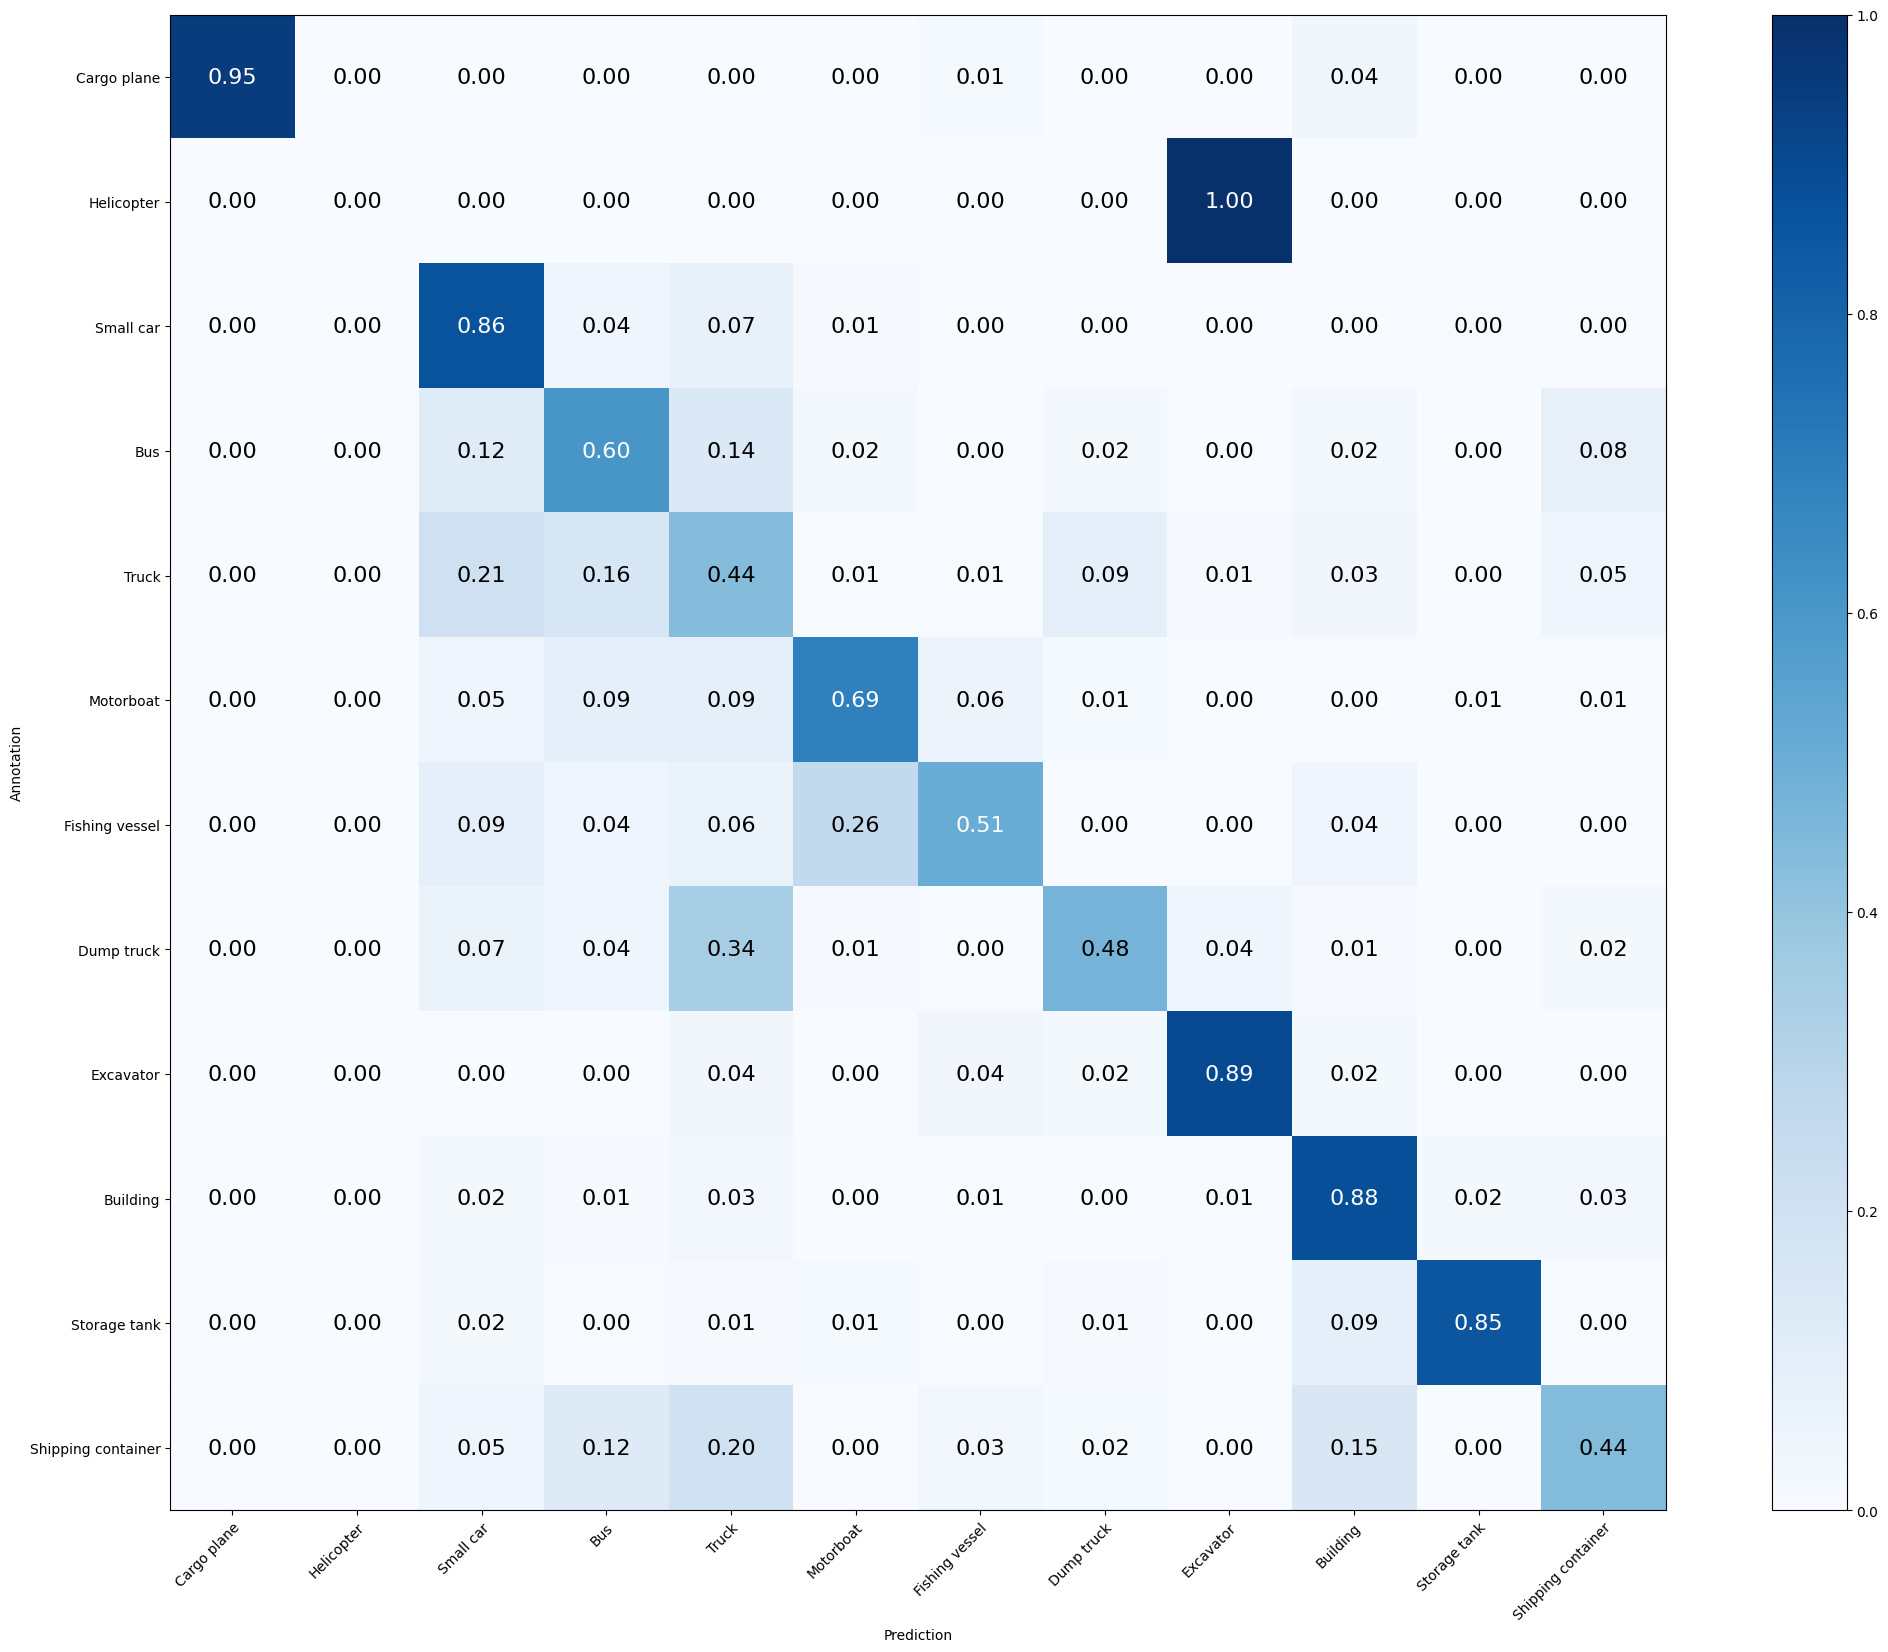

In [ ]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [ ]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 72.865%
Mean Recall: 63.274%
Mean Precision: 63.792%
> Cargo plane: Recall: 95.181% Precision: 96.341% Specificity: 99.882% Dice: 95.758%
> Helicopter: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Small car: Recall: 86.448% Precision: 74.645% Specificity: 93.343% Dice: 80.114%
> Bus: Recall: 60.331% Precision: 53.091% Specificity: 94.609% Dice: 56.480%
> Truck: Recall: 43.607% Precision: 41.824% Specificity: 92.060% Dice: 42.697%
> Motorboat: Recall: 69.036% Precision: 87.179% Specificity: 98.215% Dice: 77.054%
> Fishing vessel: Recall: 50.538% Precision: 58.025% Specificity: 98.662% Dice: 54.023%
> Dump truck: Recall: 47.541% Precision: 58.000% Specificity: 98.329% Dice: 52.252%
> Excavator: Recall: 89.474% Precision: 78.462% Specificity: 99.457% Dice: 83.607%
> Building: Recall: 88.007% Precision: 89.326% Specificity: 97.277% Dice: 88.662%
> Storage tank: Recall: 85.185% Precision: 93.665% Specificity: 99.415% Dice: 89.224%
> Shipping container

In [ ]:
!cp "/content/model.hdf5" "/content/gdrive/MyDrive/Nino/"
!cp "/content/xview_ann_test.json" "/content/gdrive/MyDrive/Nino/"
!cp "/content/xview_ann_train.json" "/content/gdrive/MyDrive/Nino/"

#### Report

You must prepare a report (PDF) describing:
* The problems and data sets (briefly).
* The process that you have followed to reach your solution for the “xview_recognition” benchmark, including your intermediate results. You must discuss and compare these results properly.
* Final network architectures, including optimization algorithms, regularization methods (dropout, data augmentation, etc.), number of layers/parameters, and performance obtained with your model on the train/valid/test data sets, including the plots of the evolution of losses and accuracy.
* It would also be very valuable your feedback on the use of “Cesvima” or “Google Colab" services.

In the submission via Moodle, attach your Python (.py) or Jupyter Notebook (.ipynb) source file, including in the report all results of computations attached to the code that generated them.

The assignment must be done in groups of 3 students.